In [1]:
include("../src/init.jl")
include("../src/fct.jl")
include("../src/fitting-fct.jl")
include("../src/worker_fct.jl")
data_type = "cal";
set = "sim";
high_cut = 4;

In [2]:
plots_path = "../plots/calib/"
base_path  = joinpath("../../waveforms/sim/", "wf")
base_path_AE  = joinpath("../../waveforms/sim/", "wf_AE")

calib_filepath = "../dicts/calib.json"
calib = JSON.parsefile(calib_filepath)
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = JSON.parsefile(cut_lib_filepath)
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = JSON.parsefile(AE_cal_filepath)

photon_lines = [583.2, 727.3, 860.6, 1592.5, 1620.7, 2103.5, 2614.5]; # keV

In [ ]:
det_lib = JSON.parsefile("../dicts/det_lib.json")
# det_lib[channel_to_name[ch]]["str"]

In [ ]:
for ch in 0:1:36
    if channel_to_bege[ch]
        ch_str = lpad(ch, 2, "0")
        config_file = glob("../../../2020-02-06_8380701d_st_ffischer/res/Impurity_Scan/config-dep/" * channel_to_name[ch] * "*.config")[1];
        str = "\$" * ch_str * "\$ & " * channel_to_name[ch] * " & \$"
        str *= string(round(parse(Float64, split(basename(config_file), "_")[3]), digits=2)) * "\$ & \$"
        str *= split(string(parse(Float64, split(basename(config_file), "_")[6])), ".")[1] * "\$ & \$"
        str *= det_lib[channel_to_name[ch]]["str"] * "\$ \\\\"
        println(str)
    end
end

In [ ]:
params = JSON.parsefile("../dicts/electronics_parameters.json")

for ch in 0:1:36
    if channel_to_bege[ch]
        ch_str = lpad(ch, 2, "0")
        str = "\$" * ch_str * "\$ & " * channel_to_name[ch]
        str *= " & \$" * string(params[channel_to_name[ch]]["par"]["GBP"]) * "\$ & "
        str *= "\$" * string(params[channel_to_name[ch]]["par"]["tau"]) * "\$ \\\\"
        println(str)
    end
end

In [ ]:
params[channel_to_name[ch]]["par"]

In [3]:
ch = 0
ch_str = lpad(ch, 2, "0");
if !channel_to_bege[ch]
    println("STOP here! This is a coax detector.")
else
    if !haskey(calib, channel_to_name[ch])
        calib[channel_to_name[ch]] = Dict()
        calib[channel_to_name[ch]]["data"] = Dict()
        calib[channel_to_name[ch]]["sim"] = Dict()
    end

    calib = JSON.parsefile(calib_filepath)
    filepath = joinpath(base_path_AE, ch_str * "-" * channel_to_name[ch] * "/AE_calibrated_smeared.h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    plots_base_path = joinpath(plots_path, ch_str * "-" * channel_to_name[ch] * "/" *set * "/")
    slice_lib_filepath = "../dicts/slice_lib.json"
    slice_filepath = "../dicts/slices_sim/"
    slice_lib = JSON.parsefile(slice_lib_filepath)
end;

In [ ]:
calib = JSON.parsefile(calib_filepath)
E = deepcopy(data.E)
A = deepcopy(data.A)
AoE = A ./ E
h = fit(Histogram, AoE, 0:0.0001:0.3)
AE_norm = h.edges[1][findfirst(x->x == maximum(h.weights), h.weights)]
AoE ./= AE_norm
h = fit(Histogram, AoE, 0:0.001:1.5)
calib[channel_to_name[ch]][set]["AE_norm"] = AE_norm
open(calib_filepath, "w") do f
    JSON.print(f, calib, 4)
end
p = plot(h, st=:step, label="All events")
p = plot!(xlabel="Normalized A/E [a.u.]", ylabel="Samples", title="Ch$ch_str", legend=:outertop, size=(1000,600))
filename = joinpath(plots_path, ch_str * "-" * channel_to_name[ch] * "/" *set * "/AoverE_all-events_norm.png")
savefig(p, filename)
display(p)

# A/E energy dependency

In [ ]:
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = isfile(AE_cal_filepath) ? JSON.parsefile(AE_cal_filepath) : Dict()
!haskey(AE_cal, channel_to_name[ch]) ? AE_cal[channel_to_name[ch]] = Dict() : ""
!haskey(AE_cal[channel_to_name[ch]], set) ? AE_cal[channel_to_name[ch]][set] = Dict() : ""

In [ ]:
mu = Dict()
mu["slice"] = []
mu["pos"] = []
mu["err"] = []
mu_lowE = Dict()
mu_lowE["slice"] = []
mu_lowE["pos"] = []
mu_lowE["err"] = []
for (k,v) in slice_lib[channel_to_name[ch]][set]["AE_slices"]
    if haskey(v, "peak")
        if parse(Float64, k) >= 1000
            push!(mu["slice"], parse(Float64, k))
            push!(mu["pos"], v["peak"][1]["μ"])
            push!(mu["err"], v["peak"][2]["μ"])
        end
        push!(mu_lowE["slice"], parse(Float64, k))
        push!(mu_lowE["pos"], v["peak"][1]["μ"])
        push!(mu_lowE["err"], v["peak"][2]["μ"])
    end
end
x = mu["slice"]
p0 = [.0, 1.0]
f = curve_fit(linmodel, x, mu["pos"], p0)
f_lowE = curve_fit(linmodel, mu_lowE["slice"], mu_lowE["pos"], p0)
x_fit = 500:10:2400
y_fit = linmodel(x_fit, f.param)
y_fit_lowE = linmodel(x_fit, f_lowE.param)
p1 = scatter(mu_lowE["slice"], mu_lowE["pos"], yerr=mu["err"], label="Data");
p1 = plot!(x_fit, y_fit, label="Fit > 1000 keV");
p1 = plot!(x_fit, y_fit_lowE, label="Fit > 600 keV");
p1 = plot!(xlabel="Energy [keV]", ylabel="A/E peak position");

AE_cal[channel_to_name[ch]][set]["lin_x"]     = mu["slice"]
AE_cal[channel_to_name[ch]][set]["lin_y"]     = mu["pos"]
AE_cal[channel_to_name[ch]][set]["lin_y_err"] = mu["err"]
AE_cal[channel_to_name[ch]][set]["lin_fit"]     = f.param
AE_cal[channel_to_name[ch]][set]["lin_fit_err"] = LsqFit.stderror(f)


sig = Dict()
sig["slice"] = []
sig["pos"] = []
sig["err"] = []
sig_lowE = Dict()
sig_lowE["slice"] = []
sig_lowE["pos"] = []
sig_lowE["err"] = []
for (k,v) in slice_lib[channel_to_name[ch]][set]["AE_slices"]
    if haskey(v, "peak")
        if parse(Float64, k) >= 1000
            push!(sig["slice"], parse(Float64, k))
            push!(sig["pos"], v["peak"][1]["σ"])
            push!(sig["err"], v["peak"][2]["σ"])
        end
        push!(sig_lowE["slice"], parse(Float64, k))
        push!(sig_lowE["pos"], v["peak"][1]["σ"])
        push!(sig_lowE["err"], v["peak"][2]["σ"])
    end
end
x = sig["slice"]
p0 = [.01, 550.0]
f = curve_fit(hypmodel, x, sig["pos"], p0, lower=[1e-6,0.0])
f_lowE = curve_fit(hypmodel, mu_lowE["slice"], sig_lowE["pos"], p0, lower=[1e-6,0.0])
x_fit = 500:10:2600
y_fit = hypmodel(x_fit, f.param)
y_fit_lowE = hypmodel(x_fit, f_lowE.param)
p2 = scatter(sig_lowE["slice"], sig_lowE["pos"], yerr=sig_lowE["err"], label="Data");
p2 = plot!(x_fit, y_fit, label="Fit > 1000 keV");
p2 = plot!(x_fit, y_fit_lowE, label="Fit > 600 keV");
p2 = plot!(xlabel="Energy [keV]", ylabel="A/E peak width");

AE_cal[channel_to_name[ch]][set]["sig_x"]     = sig["slice"]
AE_cal[channel_to_name[ch]][set]["sig_y"]     = sig["pos"]
AE_cal[channel_to_name[ch]][set]["sig_y_err"] = sig["err"]
AE_cal[channel_to_name[ch]][set]["sig_fit"]     = f.param
AE_cal[channel_to_name[ch]][set]["sig_fit_err"] = LsqFit.stderror(f)
open(AE_cal_filepath, "w") do f
    JSON.print(f, AE_cal, 4)
end
p = plot(p1, p2, size=(1200,600));
filename = joinpath(plots_path, ch_str * "-" * channel_to_name[ch] * "/" *set * "/AoverE_energy_dependency.png")
savefig(p, filename);
display(p)

# A/E Fit DEP

In [ ]:
E = deepcopy(data.E)
A = deepcopy(data.A)

E_min = calib[channel_to_name[ch]][set]["fits"]["peaks_cal"]["1592.5"][1]["μ"] - 3*calib[channel_to_name[ch]][set]["fits"]["peaks_cal"]["1592.5"][1]["σ"]
E_max = calib[channel_to_name[ch]][set]["fits"]["peaks_cal"]["1592.5"][1]["μ"] + 3*calib[channel_to_name[ch]][set]["fits"]["peaks_cal"]["1592.5"][1]["σ"]
index = findall(x->x > E_min && x < E_max, E)

AoE = A[index] ./ E[index]
AoE ./= calib[channel_to_name[ch]][set]["AE_norm"]
AoE ./= linmodel(E[index], AE_cal[channel_to_name[ch]][set]["lin_fit"])
rng_start = 0.9
rng_end = 1.05
rng_step = 0.0005
h = fit(Histogram, AoE, rng_start-0.1:rng_step:rng_end+0.1);
prior = NamedTupleDist(
    n = sum(h.weights)/10..sum(h.weights),
    σ = 1e-3..0.02,
    μ = 0.99..1.01,
    bkg_l = 0.1..20.0,
    bkg_r = 0.1..20.0,
    c = 1e3..1e4,
    d = 0.001..60.0,
    β = 0.01..1.0
)
samples = bat_fit(h, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false);

IJulia.clear_output(true)
par, err = mode(samples)[1], std(samples)[1]

x_fit = float.(midpoints(h.edges[1]))
y_fit = peak(x_fit, par)
y_fit ./= sum(y_fit)
y_fit .*= sum(h.weights)

par_tail = (n = 0, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = par.c, d = par.d, β = par.β)
y_tail = peak(x_fit, par_tail)
y_tail ./= sum(y_tail)
y_tail .*= (sum(peak(x_fit, par_tail)) / sum(peak(x_fit, par)))
y_tail .*= sum(h.weights)

par_gauss = (n = par.n, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = 0, d = par.d, β = par.β)
y_gauss = peak(x_fit, par_gauss)
y_gauss ./= sum(y_gauss)
y_gauss .*= (sum(peak(x_fit, par_gauss)) / sum(peak(x_fit, par)))
y_gauss .*= sum(h.weights)


p = plot(h, st=:step, label="Data");
p = plot!(x_fit, y_fit, label="Fit", lw=2);
p = plot!(x_fit, y_tail, label="");
p = plot!(x_fit, y_gauss, label="");
p = plot!(xlabel="Normalized A/E for DEP events [a.u.]", ylabel="Samples", legend=:outertop, size=(1000,600));
display(p)
filename = joinpath(plots_path, ch_str * "-" * channel_to_name[ch] * "/" *set * "/AoverE_DEP-peak.png");
savefig(p, filename);
AE_cal[channel_to_name[ch]][set]["DEP_fit"] = [par, err]
open(AE_cal_filepath, "w") do f
    JSON.print(f, AE_cal, 4)
end

# A/E spectrum

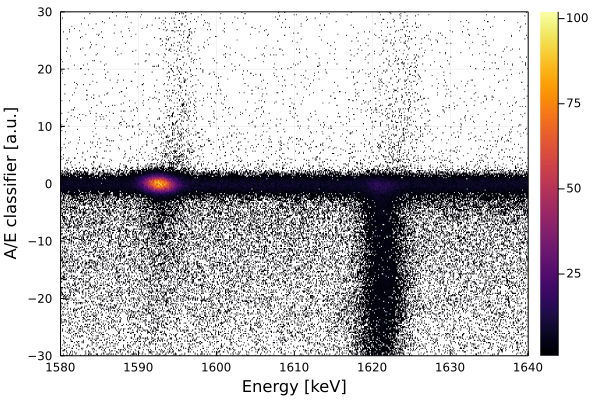

In [9]:
AE_cal = JSON.parsefile(AE_cal_filepath)
E = deepcopy(data.E)
A = deepcopy(data.A)
AoE = A ./ E
AoE ./= calib[channel_to_name[ch]][set]["AE_norm"]
AoE ./= linmodel(E, AE_cal[channel_to_name[ch]][set]["lin_fit"])
AoE ./= AE_cal[channel_to_name[ch]][set]["DEP_fit"][1]["μ"]
AoE .-= 1
AoE ./= hypmodel(E, AE_cal[channel_to_name[ch]][set]["sig_fit"])

p = histogram2d(E, AoE, bins=(1580:0.1:1640, -30:0.2:30))
p = plot!(xlabel="Energy [keV]", ylabel="A/E classifier [a.u.]")
p = plot!(framestyle=:box)
# savefig(p, "../plots/tmp/AoE_dep.png")

In [ ]:
ch = 3
ch_str = lpad(ch, 2, "0");
if !channel_to_bege[ch]
    println("STOP here! This is a coax detector.")
else
    if !haskey(calib, channel_to_name[ch])
        calib[channel_to_name[ch]] = Dict()
        calib[channel_to_name[ch]]["data"] = Dict()
        calib[channel_to_name[ch]]["sim"] = Dict()
    end

    calib = JSON.parsefile(calib_filepath)
    filepath = joinpath(base_path_AE, ch_str * "-" * channel_to_name[ch] * "/AE_calibrated_smeared.h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    plots_base_path = joinpath(plots_path, ch_str * "-" * channel_to_name[ch] * "/" *set * "/")
    slice_lib_filepath = "../dicts/slice_lib.json"
    slice_filepath = "../dicts/slices_sim/"
    slice_lib = JSON.parsefile(slice_lib_filepath)
end;

# 90% DEP acceptance cut - Sum method

In [ ]:
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = isfile(cut_lib_filepath) ? JSON.parsefile(cut_lib_filepath) : Dict()
AE_cal = JSON.parsefile(AE_cal_filepath)
# cut_lib = Dict()
!haskey(cut_lib, channel_to_name[ch]) ? cut_lib[channel_to_name[ch]] = Dict() : ""
!haskey(cut_lib[channel_to_name[ch]], set) ? cut_lib[channel_to_name[ch]][set] = Dict() : ""
E = deepcopy(data.E)
A = deepcopy(data.A)

AoE = A ./ E
AoE ./= calib[channel_to_name[ch]][set]["AE_norm"]
AoE ./= linmodel(E, AE_cal[channel_to_name[ch]][set]["lin_fit"])
AoE ./= AE_cal[channel_to_name[ch]][set]["DEP_fit"][1]["μ"]
AoE .-= 1
AoE ./= hypmodel(E, AE_cal[channel_to_name[ch]][set]["sig_fit"])

rng_step  = 0.15
rng_width = 20
rng = 1592.5-rng_width:rng_step:1592.5+rng_width


### DEP reference fit after high cut

In [ ]:
index = findall(x-> x < high_cut, AoE)
index = eachindex(AoE)
h = fit(Histogram, E[index], rng)

p0_dict = calib[channel_to_name[ch]][set]["fits"]["peaks_cal"]["1592.5"][1]
p0 = (
    n = p0_dict["n"],
    σ = p0_dict["σ"],
    μ = p0_dict["μ"],
    bkg_l = p0_dict["bkg_l"],
    bkg_r = p0_dict["bkg_r"],
    c = 1,#p0_dict["c"],
    d = p0_dict["d"],
    β = p0_dict["β"]
)
prior = NamedTupleDist(
    n = p0.n/20..p0.n*30,
    σ = p0.σ/1.75..p0.σ*1.75,
    μ = p0.µ - 3..p0.µ + 3,
    bkg_l = 0.1..p0.bkg_l*30,
    bkg_r = 0.1..p0.bkg_r*30,
    c = p0.c/10..p0.c*1.10,
    d = p0.d/10..p0.d*10,
    β = 0.2..p0.β*20
)


samples = try bat_fit(h, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false)
catch 
    IJulia.clear_output(true)
    bat_fit(h, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false)
end
IJulia.clear_output(true)

par, err = mode(samples)[1], std(samples)[1]

In [ ]:
x_fit = float.(midpoints(h.edges[1]))
y_fit = peak(x_fit, par)
y_fit ./= sum(y_fit)
y_fit .*= sum(h.weights)

par_tail = (n = 0, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = par.c, d = par.d, β = par.β)
y_tail = peak(x_fit, par_tail)
y_tail ./= sum(y_tail)
y_tail .*= (sum(peak(x_fit, par_tail)) / sum(peak(x_fit, par)))
y_tail .*= sum(h.weights)

par_gauss = (n = par.n, σ = par.σ, μ = par.µ, bkg_l = 0, bkg_r = 0, c = 0, d = par.d, β = par.β)
y_gauss = peak(x_fit, par_gauss)
y_gauss ./= sum(y_gauss)
y_gauss .*= (sum(peak(x_fit, par_gauss)) / sum(peak(x_fit, par)))
y_gauss .*= sum(h.weights)

# E_range = string(slices[slice]) * "-" * string(slices[slice] + 30)
p = plot(h, st=:step, label="Data");
p = plot!(x_fit, y_fit, label="Fit", lw=2);
p = plot!(x_fit, y_tail, label="");
p = plot!(x_fit, y_gauss, label="");
p = plot!(xlabel="Energy [keV]", ylabel="Samples", size=(800,600))

cut_lib[channel_to_name[ch]][set]["DEP_ref"] = [par, err]
open(cut_lib_filepath, "w") do f
    JSON.print(f, cut_lib, 4)
end
p

### Counting Method

In [ ]:
cut_lib = JSON.parsefile(cut_lib_filepath)
# rng_width = 25
# rng = 1592.5-rng_width:rng_step:1592.5+rng_width


# index = findall(x-> x < high_cut, AoE)
index = eachindex(AoE)

parNoCut_dict = cut_lib[channel_to_name[ch]][set]["DEP_ref"][1]
parNoCut = (
    n = parNoCut_dict["n"],
    σ = parNoCut_dict["σ"],
    μ = parNoCut_dict["μ"],
    bkg_l = parNoCut_dict["bkg_l"],
    bkg_r = parNoCut_dict["bkg_r"],
    c = parNoCut_dict["c"],
    d = parNoCut_dict["d"],
    β = parNoCut_dict["β"]
)
x_fit = float.(midpoints(h.edges[1]))
y_fit = peak(x_fit, par)
y_fit ./= sum(y_fit)
y_fit .*= sum(h.weights)

h = fit(Histogram, E[index], rng)

det_lib = JSON.parsefile("../dicts/det_lib.json")
ds = det_lib[channel_to_name[ch]]["ds"]
datasets_str = [
    "0053-0064",
    "0065-0079",
    "0080-0092",
    "0093-0113"
]

sig_shift = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["summing"]["sig_shift"]
sig_num = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["summing"]["sig_num"]
# sig_shift = 2.5
# sig_num = 2.5
hist_step_size = rng_step

indexDEP = findall(x -> x >= parNoCut.µ - sig_num * parNoCut.σ && x <= parNoCut.µ + sig_num * parNoCut.σ, E[index])
indexBkg = findall(x -> x >= parNoCut.µ - (2 * sig_num + sig_shift) * parNoCut.σ && x < parNoCut.µ - (sig_num + sig_shift) * parNoCut.σ || x <= parNoCut.µ + (2 * sig_num + sig_shift) * parNoCut.σ && x > parNoCut.µ + (sig_num + sig_shift) * parNoCut.σ, E[index])
hDEP = fit(Histogram, E[index][indexDEP], parNoCut.µ - sig_num * parNoCut.σ:hist_step_size:parNoCut.µ + sig_num * parNoCut.σ)
hBkg = fit(Histogram, E[index][indexBkg], parNoCut.µ - (2 * sig_num + sig_shift) * parNoCut.σ:hist_step_size:parNoCut.µ + (2 * sig_num + sig_shift) * parNoCut.σ)
p = plot(h, st=:step, label="Data")
p = plot!(x_fit, y_fit, label="no cut")
p = plot!(hDEP, st=:step)
p = plot!(hBkg, st=:step)
p = plot!(size=(1000, 600), xlabel="Energy [keV]", ylabel="Samples", legend=false)
display(p)

AE_rng = floor(minimum(AoE[index][indexDEP]), digits=1) - 0.05:0.1:ceil(maximum(AoE[index][index[indexDEP]]))
AE_DEP = fit(Histogram, AoE[index][indexDEP], AE_rng)
AE_Bkg = fit(Histogram, AoE[index][indexBkg], AE_rng)

hNew = fit(Histogram, AoE[index][indexDEP], AE_rng)
hNew.weights = AE_DEP.weights .- AE_Bkg.weights;

p = plot(AE_DEP, st=:step)
p = plot!(AE_Bkg, st=:step)
p = plot!(hNew, st=:step)


index_high_cut = findall(x->x >= 4, midpoints(hNew.edges[1]))
index_no_high_cut = findall(x->x < 4, midpoints(hNew.edges[1]))
cumulative = []
c = 0
for i in eachindex(hNew.weights)
    c += hNew.weights[i]
    push!(cumulative, c)
end

x = midpoints(hNew.edges[1])
y = 1 .- cumulative ./ sum(hNew.weights)
index_cut = findall(x->x >= -15 && x <= 0, midpoints(hNew.edges[1]))
x = x[index_cut]
y = y[index_cut]
cumulative = cumulative[index_cut]

y_err = []
for i in eachindex(x)
    k = cumulative[i]
    N = sum(hNew.weights)
    err = (1/N) * sqrt(abs(k*(1-k/N)))
    push!(y_err, err)
end

survival_mwa = movingaverage(y, 3)
s = float.(survival_mwa)
itp = interpolate(s, BSpline(Cubic(Line(OnGrid())))) 
sitp = Interpolations.scale(itp, round(minimum(x), digits=3):round(x[2] - x[1], digits=3):round(maximum(x), digits=3));
p = scatter(x, y, yerr=y_err, label=channel_to_name[ch] * " - " * set)
p = plot!(x, survival_mwa, label="MWA", lw=3)
p = hline!([0.9], label="90% acceptance")

if maximum(sitp) > 0.9
    start = findfirst(x -> x < 0.9, s) - 2
    cut_x = x[start]
    while true
        round(sitp[cut_x], digits=5) <= 0.9 ? break : cut_x += 0.0001
    end

    p = vline!([cut_x], label=string(round(cut_x, digits=2)))
end

cut_lib[channel_to_name[ch]][set]["summing"] = Dict()
cut_lib[channel_to_name[ch]][set]["summing"]["sig_shift"] = sig_shift
cut_lib[channel_to_name[ch]][set]["summing"]["sig_num"] = sig_num
cut_lib[channel_to_name[ch]][set]["summing"]["hist_step_size"] = hist_step_size
cut_lib[channel_to_name[ch]][set]["summing"]["cuts"] = x
cut_lib[channel_to_name[ch]][set]["summing"]["sf"] = y
cut_lib[channel_to_name[ch]][set]["summing"]["sf_err"] = y_err
cut_lib[channel_to_name[ch]][set]["summing"]["cut"] = maximum(sitp) > 0.9 ? cut_x : -10


open(cut_lib_filepath, "w") do f
    JSON.print(f, cut_lib, 4)
end

p = plot!(size=(1000,600), ylim=(0,1), xlim=(-5,-0.5), xlabel="A/E classifier cut [a.u.]", ylabel="DEP survival fraction")
p = plot!(legend=:outertop)
display(p)

In [ ]:
sig_shift, sig_num

In [ ]:
cut_lib = JSON.parsefile(cut_lib_filepath)
x_fit_cut = cut_lib[channel_to_name[ch]][set]["fitting"]["cut"]
x_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["cuts"]
y_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf"]
y_err_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf_err"]

x_sum_cut = cut_lib[channel_to_name[ch]][set]["summing"]["cut"]
x_sum = cut_lib[channel_to_name[ch]][set]["summing"]["cuts"]
y_sum = cut_lib[channel_to_name[ch]][set]["summing"]["sf"]
y_err_sum = cut_lib[channel_to_name[ch]][set]["summing"]["sf_err"]

p = plot(xlabel="A/E classifier [a.u.]", ylabel="DEP survival fraction", size=(1000,600), legend=:outertopright, xlim=(-5,-0.5))
p = plot!(title="Ch" * ch_str * " | 90% DEP acceptance determination")

p = scatter!(x_fit, y_fit, yerr=y_err_fit, label="Fit method")
p = plot!(x_fit, movingaverage(y_fit, 3), label="Fit method (MWA)")
p = vline!([x_fit_cut], label="Fit cut: " * string(round(x_fit_cut, digits=2)))

p = scatter!(x_sum, y_sum, yerr=y_err_sum, label="Sum method")
p = plot!(x_sum, movingaverage(y_sum, 3), label="Sum method (MWA)")
p = vline!([x_sum_cut], label="Sum cut: " * string(round(x_sum_cut, digits=2)))

In [ ]:
index_high_cut = findall(x->x >= 4, midpoints(hNew.edges[1]))
index_no_high_cut = findall(x->x < 4, midpoints(hNew.edges[1]))
sum(hNew.weights[index_high_cut])/sum(hNew.weights)

In [ ]:
cumulative = []
c = 0
for i in eachindex(hNew.weights)
    c += hNew.weights[i]
    push!(cumulative, c)
end

# 90% DEP acceptance cut - Fit Method

In [ ]:
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = JSON.parsefile(cut_lib_filepath)
cut_lib[channel_to_name[ch]][set]
E = deepcopy(data.E)
A = deepcopy(data.A)
# rng_width = 15
# rng = 1592.5-rng_width:rng_step:1592.5+rng_width

AoE = A ./ E
AoE ./= calib[channel_to_name[ch]][set]["AE_norm"]
AoE ./= linmodel(E, AE_cal[channel_to_name[ch]][set]["lin_fit"])
AoE ./= AE_cal[channel_to_name[ch]][set]["DEP_fit"][1]["μ"]
AoE .-= 1
AoE ./= hypmodel(E, AE_cal[channel_to_name[ch]][set]["sig_fit"])

# rng_step  = 0.1
rng_width = 20
rng = 1592.5-rng_width:rng_step:1592.5+rng_width

# index = findall(x-> x < high_cut, AoE)
index = eachindex(AoE)
h = fit(Histogram, E[index], rng)

parNoCut_dict = cut_lib[channel_to_name[ch]][set]["DEP_ref"][1]
parNoCut = (
    n = parNoCut_dict["n"],
    σ = parNoCut_dict["σ"],
    μ = parNoCut_dict["μ"],
    bkg_l = parNoCut_dict["bkg_l"],
    bkg_r = parNoCut_dict["bkg_r"],
    c = parNoCut_dict["c"],
    d = parNoCut_dict["d"],
    β = parNoCut_dict["β"]
)
x_fit = float.(midpoints(h.edges[1]))
y_fit = peak(x_fit, parNoCut)
y_fit ./= sum(y_fit)
y_fit .*= sum(h.weights)

h = fit(Histogram, E[index], rng)
p = plot(h, st=:step)
p = plot!(x_fit, y_fit)
display(p)
parNoCut

In [ ]:
!haskey(cut_lib[channel_to_name[ch]][set], "fitting") ? cut_lib[channel_to_name[ch]][set]["fitting"] = Dict() : ""
cut_lib[channel_to_name[ch]][set]["fitting"]["fits"] = Dict()
open(cut_lib_filepath, "w") do f
    JSON.print(f, cut_lib, 4)
end
cuts = (-4):0.1:(0.0)
@showprogress 1 "Fitting survival fractions" for c in eachindex(cuts)
    cut = cuts[c]

    cut_lib = JSON.parsefile(cut_lib_filepath)
    indexCut =  findall(x-> cut < x, AoE)
    
    hCut = fit(Histogram, E[indexCut], rng)
    
    if c == 1
        p0 = deepcopy(parNoCut)
        prior = NamedTupleDist(
            n = p0.n/5..p0.n*1.2,
            σ = p0.σ/1.5..p0.σ*1.5,
            μ = p0.µ - 3..p0.µ + 3,
            bkg_l = 0.1..p0.bkg_l*2,
            bkg_r = 0.1..p0.bkg_r*2,
            c = p0.c/10..p0.c*1.01,
            d = p0.d/10..p0.d*5,
            β = 0.2..p0.β*10
        )
    elseif haskey(cut_lib[channel_to_name[ch]][set]["fitting"]["fits"], string(cuts[c-1]))
        p0_dict = cut_lib[channel_to_name[ch]][set]["fitting"]["fits"][string(cuts[c-1])][1]
        p0 = (
            n = p0_dict["n"],
            σ = p0_dict["σ"],
            μ = p0_dict["μ"],
            bkg_l = p0_dict["bkg_l"],
            bkg_r = p0_dict["bkg_r"],
            c = p0_dict["c"],
            d = p0_dict["d"],
            β = p0_dict["β"]
        )
        prior = NamedTupleDist(
            n = p0.n/1.1..p0.n*1.1,
            σ = p0.σ/1.1..p0.σ*1.1,
            μ = p0.µ - 0.5..p0.µ + 0.5,
            bkg_l = p0.bkg_l/1.1..p0.bkg_l*1.1,
            bkg_r = p0.bkg_r/1.1..p0.bkg_r*1.1,
            c = p0.c/1.1..p0.c*1.01,
            d = p0.d/1.1..p0.d*1.1,
            β = p0.β/1.1..p0.β*1.1
        )
    else
        p0 = deepcopy(parNoCut)
        prior = NamedTupleDist(
            n = p0.n/5..p0.n*1.2,
            σ = p0.σ/1.5..p0.σ*1.5,
            μ = p0.µ - 3..p0.µ + 3,
            bkg_l = 0.1..p0.bkg_l*2,
            bkg_r = 0.1..p0.bkg_r*2,
            c = p0.c/10..p0.c*1.01,
            d = p0.d/10..p0.d*5,
            β = 0.1..p0.β*10
        )
    end
    fail = false
    display(plot(hCut, st=:step))
#     samples = bat_fit(hCut, peak, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
    samples = try bat_fit(hCut, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
    catch 
        try bat_fit(hCut, peak, prior; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=false)
        catch
            try bat_fit(hCut, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false)
            catch 
                fail = true
            end
        end
    end
    
    IJulia.clear_output(true)
    if !fail
        parCut, errCut = mode(samples)[1], std(samples)[1]

        k = (parCut[1] + parCut[6])# * calCut
        N = (parNoCut[1] + parNoCut[6]) #* calNoCut
        sf = k/N
        sf_err = (1/N) * sqrt(abs(k*(1-k/N)))
        sf, sf_err

        !haskey(cut_lib[channel_to_name[ch]][set], "fitting") ? cut_lib[channel_to_name[ch]][set]["fitting"] = Dict() : ""
        !haskey(cut_lib[channel_to_name[ch]][set]["fitting"], "fits") ? cut_lib[channel_to_name[ch]][set]["fitting"]["fits"] = Dict() : ""
        cut_lib[channel_to_name[ch]][set]["fitting"]["fits"][string(cut)] = [parCut, errCut, sf, sf_err]
        cut_lib[channel_to_name[ch]][set]["fitting"]["hist_step_size"] = rng_step
        open(cut_lib_filepath, "w") do f
            JSON.print(f, cut_lib, 4)
        end

        x_fit = float.(midpoints(h.edges[1]))
        y_fit = peak(x_fit, parNoCut)
        y_fit ./= sum(y_fit)
        y_fit .*= sum(h.weights)

        h = fit(Histogram, E[index], rng)
        p = plot(h, st=:step, label="Data no cut")
        p = plot!(x_fit, y_fit, label="Fit no cut")

        x_fit = float.(midpoints(hCut.edges[1]))
        y_fit = peak(x_fit, parCut)
        y_fit ./= sum(y_fit)
        y_fit .*= sum(hCut.weights)

        p = plot!(hCut, st=:step, label="Data cut: " * string(cut))
        p = plot!(x_fit, y_fit, label="Fit survival: " * string(round(sf*100, digits=1)) * " %")
        display(p)
    else
        @info("FAIL for " * string(cuts[c]))
    end
end

In [ ]:
x = []
y = []
y_err = []
for (k,v) in cut_lib[channel_to_name[ch]][set]["fitting"]["fits"]
    if parse(Float64, k) > -5
        push!(x, parse(Float64, k))
        push!(y, v[3])
        push!(y_err, v[4])
    end
end
x_sort = sort(x)
y_sort = []
y_err_sort = []
for x1 in x_sort
    i = findfirst(a-> a == x1, x)
    push!(y_sort, y[i])
    push!(y_err_sort, y_err[i])
end
x = x_sort
y = y_sort
y_err = y_err_sort
survival_mwa = movingaverage(y, 3)
s = float.(survival_mwa)
itp = interpolate(s, BSpline(Cubic(Line(OnGrid())))) 
sitp = Interpolations.scale(itp, round(minimum(x), digits=3):round(x[2] - x[1], digits=3):round(maximum(x), digits=3));
p = scatter(x, y, yerr=y_err, label=channel_to_name[ch] * " - " * set)
p = plot!(x, survival_mwa, label="MWA", lw=3)
p = hline!([0.9], label="90% acceptance")
if maximum(sitp) > 0.9
    start = findfirst(x -> x < 0.9, s) - 2
    cut_x = x[start]
    while true
        round(sitp[cut_x], digits=5) <= 0.9 ? break : cut_x += 0.0001
    end

    p = vline!([cut_x], label=string(round(cut_x, digits=2)))
end
cut_lib[channel_to_name[ch]][set]["fitting"]["cut"] = maximum(sitp) > 0.9 ? cut_x : -10
cut_lib[channel_to_name[ch]][set]["fitting"]["cuts"] = x
cut_lib[channel_to_name[ch]][set]["fitting"]["sf"] = y
cut_lib[channel_to_name[ch]][set]["fitting"]["sf_err"] = y_err
open(cut_lib_filepath, "w") do f
    JSON.print(f, cut_lib, 4)
end
p

In [ ]:
cut_lib = JSON.parsefile(cut_lib_filepath)
x_fit_cut = cut_lib[channel_to_name[ch]][set]["fitting"]["cut"]
x_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["cuts"]
y_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf"]
y_err_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf_err"]

x_sum_cut = cut_lib[channel_to_name[ch]][set]["summing"]["cut"]
x_sum = cut_lib[channel_to_name[ch]][set]["summing"]["cuts"]
y_sum = cut_lib[channel_to_name[ch]][set]["summing"]["sf"]
y_err_sum = cut_lib[channel_to_name[ch]][set]["summing"]["sf_err"]

p = plot(xlabel="A/E classifier [a.u.]", ylabel="DEP survival fraction", size=(1000,600), legend=:outertopright, xlim=(-5,-0.5))
p = plot!(title="Ch" * ch_str * " | 90% DEP acceptance determination")

p = scatter!(x_fit, y_fit, yerr=y_err_fit, label="Fit method")
p = plot!(x_fit, movingaverage(y_fit, 3), label="Fit method (MWA)")
p = vline!([x_fit_cut], label="Fit cut: " * string(round(x_fit_cut, digits=2)))

p = scatter!(x_sum, y_sum, yerr=y_err_sum, label="Sum method")
p = plot!(x_sum, movingaverage(y_sum, 3), label="Sum method (MWA)")
p = vline!([x_sum_cut], label="Sum cut: " * string(round(x_sum_cut, digits=2)))

In [ ]:
ch = 1
ch_str = lpad(ch, 2, "0")

# p = plot!(title="Ch" * ch_str * " | 90% DEP acceptance determination | Fitting")

cut_lib = JSON.parsefile(cut_lib_filepath)
x_fit_cut = cut_lib[channel_to_name[ch]][set]["fitting"]["cut"]
x_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["cuts"]
y_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf"]
y_err_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf_err"]

x_fit_sim = deepcopy(x_fit)
y_fit_sim = deepcopy(y_fit)
y_err_sim = deepcopy(y_err_fit)
x_cut_sim = deepcopy(x_fit_cut)


det_lib = JSON.parsefile("../dicts/det_lib.json")
ds = det_lib[channel_to_name[ch]]["ds"]
datasets_str = [
    "0053-0064",
    "0065-0079",
    "0080-0092",
    "0093-0113"
]

x_fit_cut = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["cut"]
x_fit = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["cuts"]
y_fit = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["sf"]
y_err_fit = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["sf_err"]

x_fit_data = deepcopy(x_fit)
y_fit_data = deepcopy(y_fit)
y_err_data = deepcopy(y_err_fit)
x_cut_data = deepcopy(x_fit_cut)


p = plot(xlabel="Cut value [a.u.]", ylabel="DEP survival fraction [%]", legend=:bottomleft, xlim=(-3,-0.5), ylim=(60,100), framestyle=:box)#, size=(1000,600)
p = scatter!(x_fit_data, y_fit_data.*100, yerr=y_err_data.*100, label="Data", color="#009AF9", markersize=3)
p = plot!(x_fit_data, movingaverage(y_fit_data, 3).*100, label="", lw=2, color="#009AF9")
p = scatter!(x_fit_sim, y_fit_sim.*100, yerr=y_err_fit.*100, label="Simulation", color="#E26F46", markersize=3)
p = plot!(x_fit_sim, movingaverage(y_fit_sim, 3).*100, label="", lw=2, color="#E26F46")
p = vline!([x_cut_data], label="Data cut: " * string(round(x_cut_data, digits=2)), color="#009AF9")
p = vline!([x_cut_sim], label="Sim. cut: " * string(round(x_cut_sim, digits=2)), color="#E26F46")
p = hline!([90], label="", style=:dash, color=:black)

In [ ]:
channels_done

# START

In [ ]:
channels_done = []

In [ ]:
for ch in 25:1:36
    if channel_to_bege[ch] == false || ch in channels_done || ch in [5,6,7,13]
        continue
    end
    ch_str = lpad(ch, 2, "0");
    if !channel_to_bege[ch]
        println("STOP here! This is a coax detector.")
    else
        if !haskey(calib, channel_to_name[ch])
            calib[channel_to_name[ch]] = Dict()
            calib[channel_to_name[ch]]["data"] = Dict()
            calib[channel_to_name[ch]]["sim"] = Dict()
        end

        calib = JSON.parsefile(calib_filepath)
        filepath = joinpath(base_path_AE, ch_str * "-" * channel_to_name[ch] * "/AE_calibrated_smeared.h5")
        data = HDF5.h5open(filepath, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end;
        plots_base_path = joinpath(plots_path, ch_str * "-" * channel_to_name[ch] * "/" *set * "/")
        slice_lib_filepath = "../dicts/slice_lib.json"
        slice_filepath = "../dicts/slices_sim/"
        slice_lib = JSON.parsefile(slice_lib_filepath)
    end;


    cut_lib_filepath = "../dicts/cut_lib.json"
    cut_lib = isfile(cut_lib_filepath) ? JSON.parsefile(cut_lib_filepath) : Dict()
    AE_cal = JSON.parsefile(AE_cal_filepath)
    # cut_lib = Dict()
    !haskey(cut_lib, channel_to_name[ch]) ? cut_lib[channel_to_name[ch]] = Dict() : ""
    !haskey(cut_lib[channel_to_name[ch]], set) ? cut_lib[channel_to_name[ch]][set] = Dict() : ""
    E = deepcopy(data.E)
    A = deepcopy(data.A)

    AoE = A ./ E
    AoE ./= calib[channel_to_name[ch]][set]["AE_norm"]
    AoE ./= linmodel(E, AE_cal[channel_to_name[ch]][set]["lin_fit"])
    AoE ./= AE_cal[channel_to_name[ch]][set]["DEP_fit"][1]["μ"]
    AoE .-= 1
    AoE ./= hypmodel(E, AE_cal[channel_to_name[ch]][set]["sig_fit"])

    rng_step  = 0.15
    rng_width = 20
    rng = 1592.5-rng_width:rng_step:1592.5+rng_width


    index = findall(x-> x < high_cut, AoE)
    index = eachindex(AoE)
    h = fit(Histogram, E[index], rng)

    p0_dict = calib[channel_to_name[ch]][set]["fits"]["peaks_cal"]["1592.5"][1]
    p0 = (
        n = p0_dict["n"],
        σ = p0_dict["σ"],
        μ = p0_dict["μ"],
        bkg_l = p0_dict["bkg_l"],
        bkg_r = p0_dict["bkg_r"],
        c = 1,#p0_dict["c"],
        d = p0_dict["d"],
        β = p0_dict["β"]
    )
    prior = NamedTupleDist(
        n = p0.n/20..p0.n*30,
        σ = p0.σ/1.75..p0.σ*1.75,
        μ = p0.µ - 3..p0.µ + 3,
        bkg_l = 0.1..p0.bkg_l*30,
        bkg_r = 0.1..p0.bkg_r*30,
        c = p0.c/10..p0.c*1.10,
        d = p0.d/10..p0.d*10,
        β = 0.2..p0.β*20
    )


    samples = try bat_fit(h, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false)
    catch 
        IJulia.clear_output(true)
        bat_fit(h, peak, prior; nsamples=10*10^5, nchains=4, params_first=false, norm_expected=false)
    end
    IJulia.clear_output(true)

    par, err = mode(samples)[1], std(samples)[1]


    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, par)
    y_fit ./= sum(y_fit)
    y_fit .*= sum(h.weights)

    par_tail = (n = 0, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = par.c, d = par.d, β = par.β)
    y_tail = peak(x_fit, par_tail)
    y_tail ./= sum(y_tail)
    y_tail .*= (sum(peak(x_fit, par_tail)) / sum(peak(x_fit, par)))
    y_tail .*= sum(h.weights)

    par_gauss = (n = par.n, σ = par.σ, μ = par.µ, bkg_l = 0, bkg_r = 0, c = 0, d = par.d, β = par.β)
    y_gauss = peak(x_fit, par_gauss)
    y_gauss ./= sum(y_gauss)
    y_gauss .*= (sum(peak(x_fit, par_gauss)) / sum(peak(x_fit, par)))
    y_gauss .*= sum(h.weights)

    # E_range = string(slices[slice]) * "-" * string(slices[slice] + 30)
    p = plot(h, st=:step, label="Data");
    p = plot!(x_fit, y_fit, label="Fit", lw=2);
    p = plot!(x_fit, y_tail, label="");
    p = plot!(x_fit, y_gauss, label="");
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", size=(800,600))

    cut_lib[channel_to_name[ch]][set]["DEP_ref"] = [par, err]
    open(cut_lib_filepath, "w") do f
        JSON.print(f, cut_lib, 4)
    end
    display(p)


    cut_lib = JSON.parsefile(cut_lib_filepath)
    # rng_width = 25
    # rng = 1592.5-rng_width:rng_step:1592.5+rng_width


    # index = findall(x-> x < high_cut, AoE)
    index = eachindex(AoE)

    parNoCut_dict = cut_lib[channel_to_name[ch]][set]["DEP_ref"][1]
    parNoCut = (
        n = parNoCut_dict["n"],
        σ = parNoCut_dict["σ"],
        μ = parNoCut_dict["μ"],
        bkg_l = parNoCut_dict["bkg_l"],
        bkg_r = parNoCut_dict["bkg_r"],
        c = parNoCut_dict["c"],
        d = parNoCut_dict["d"],
        β = parNoCut_dict["β"]
    )
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, par)
    y_fit ./= sum(y_fit)
    y_fit .*= sum(h.weights)

    h = fit(Histogram, E[index], rng)

    det_lib = JSON.parsefile("../dicts/det_lib.json")
    ds = det_lib[channel_to_name[ch]]["ds"]
    datasets_str = [
        "0053-0064",
        "0065-0079",
        "0080-0092",
        "0093-0113"
    ]

    sig_shift = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["summing"]["sig_shift"]
    sig_num = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["summing"]["sig_num"]
#     sig_shift = 3
#     sig_num = 3
    hist_step_size = rng_step

    indexDEP = findall(x -> x >= parNoCut.µ - sig_num * parNoCut.σ && x <= parNoCut.µ + sig_num * parNoCut.σ, E[index])
    indexBkg = findall(x -> x >= parNoCut.µ - (2 * sig_num + sig_shift) * parNoCut.σ && x < parNoCut.µ - (sig_num + sig_shift) * parNoCut.σ || x <= parNoCut.µ + (2 * sig_num + sig_shift) * parNoCut.σ && x > parNoCut.µ + (sig_num + sig_shift) * parNoCut.σ, E[index])
    hDEP = fit(Histogram, E[index][indexDEP], parNoCut.µ - sig_num * parNoCut.σ:hist_step_size:parNoCut.µ + sig_num * parNoCut.σ)
    hBkg = fit(Histogram, E[index][indexBkg], parNoCut.µ - (2 * sig_num + sig_shift) * parNoCut.σ:hist_step_size:parNoCut.µ + (2 * sig_num + sig_shift) * parNoCut.σ)
    p = plot(h, st=:step, label="Data")
    p = plot!(x_fit, y_fit, label="no cut")
    p = plot!(hDEP, st=:step)
    p = plot!(hBkg, st=:step)
    p = plot!(size=(1000, 600), xlabel="Energy [keV]", ylabel="Samples", legend=false)
    display(p)

    AE_rng = floor(minimum(AoE[index][indexDEP]), digits=1) - 0.05:0.1:ceil(maximum(AoE[index][index[indexDEP]]))
    AE_DEP = fit(Histogram, AoE[index][indexDEP], AE_rng)
    AE_Bkg = fit(Histogram, AoE[index][indexBkg], AE_rng)

    hNew = fit(Histogram, AoE[index][indexDEP], AE_rng)
    hNew.weights = AE_DEP.weights .- AE_Bkg.weights;

    p = plot(AE_DEP, st=:step)
    p = plot!(AE_Bkg, st=:step)
    p = plot!(hNew, st=:step)


    index_high_cut = findall(x->x >= 4, midpoints(hNew.edges[1]))
    index_no_high_cut = findall(x->x < 4, midpoints(hNew.edges[1]))
    cumulative = []
    c = 0
    for i in eachindex(hNew.weights)
        c += hNew.weights[i]
        push!(cumulative, c)
    end

    x = midpoints(hNew.edges[1])
    y = 1 .- cumulative ./ sum(hNew.weights)
    index_cut = findall(x->x >= -15 && x <= 0, midpoints(hNew.edges[1]))
    x = x[index_cut]
    y = y[index_cut]
    cumulative = cumulative[index_cut]

    y_err = []
    for i in eachindex(x)
        k = cumulative[i]
        N = sum(hNew.weights)
        err = (1/N) * sqrt(abs(k*(1-k/N)))
        push!(y_err, err)
    end

    survival_mwa = movingaverage(y, 3)
    s = float.(survival_mwa)
    itp = interpolate(s, BSpline(Cubic(Line(OnGrid())))) 
    sitp = Interpolations.scale(itp, round(minimum(x), digits=3):round(x[2] - x[1], digits=3):round(maximum(x), digits=3));
    p = scatter(x, y, yerr=y_err, label=channel_to_name[ch] * " - " * set)
    p = plot!(x, survival_mwa, label="MWA", lw=3)
    p = hline!([0.9], label="90% acceptance")

    if maximum(sitp) > 0.9
        start = findfirst(x -> x < 0.9, s) - 2
        cut_x = x[start]
        while true
            round(sitp[cut_x], digits=5) <= 0.9 ? break : cut_x += 0.0001
        end

        p = vline!([cut_x], label=string(round(cut_x, digits=2)))
    end

    cut_lib[channel_to_name[ch]][set]["summing"] = Dict()
    cut_lib[channel_to_name[ch]][set]["summing"]["sig_shift"] = sig_shift
    cut_lib[channel_to_name[ch]][set]["summing"]["sig_num"] = sig_num
    cut_lib[channel_to_name[ch]][set]["summing"]["hist_step_size"] = hist_step_size
    cut_lib[channel_to_name[ch]][set]["summing"]["cuts"] = x
    cut_lib[channel_to_name[ch]][set]["summing"]["sf"] = y
    cut_lib[channel_to_name[ch]][set]["summing"]["sf_err"] = y_err
    cut_lib[channel_to_name[ch]][set]["summing"]["cut"] = maximum(sitp) > 0.9 ? cut_x : -10


    open(cut_lib_filepath, "w") do f
        JSON.print(f, cut_lib, 4)
    end

    p = plot!(size=(1000,600), ylim=(0,1), xlim=(-5,-0.5), xlabel="A/E classifier cut [a.u.]", ylabel="DEP survival fraction")
    p = plot!(legend=:outertop)
    display(p)


    cut_lib_filepath = "../dicts/cut_lib.json"
    cut_lib = JSON.parsefile(cut_lib_filepath)
    cut_lib[channel_to_name[ch]][set]
    E = deepcopy(data.E)
    A = deepcopy(data.A)
    # rng_width = 15
    # rng = 1592.5-rng_width:rng_step:1592.5+rng_width

    AoE = A ./ E
    AoE ./= calib[channel_to_name[ch]][set]["AE_norm"]
    AoE ./= linmodel(E, AE_cal[channel_to_name[ch]][set]["lin_fit"])
    AoE ./= AE_cal[channel_to_name[ch]][set]["DEP_fit"][1]["μ"]
    AoE .-= 1
    AoE ./= hypmodel(E, AE_cal[channel_to_name[ch]][set]["sig_fit"])

    # rng_step  = 0.1
    rng_width = 20
    rng = 1592.5-rng_width:rng_step:1592.5+rng_width

    # index = findall(x-> x < high_cut, AoE)
    index = eachindex(AoE)
    h = fit(Histogram, E[index], rng)

    parNoCut_dict = cut_lib[channel_to_name[ch]][set]["DEP_ref"][1]
    parNoCut = (
        n = parNoCut_dict["n"],
        σ = parNoCut_dict["σ"],
        μ = parNoCut_dict["μ"],
        bkg_l = parNoCut_dict["bkg_l"],
        bkg_r = parNoCut_dict["bkg_r"],
        c = parNoCut_dict["c"],
        d = parNoCut_dict["d"],
        β = parNoCut_dict["β"]
    )
    x_fit = float.(midpoints(h.edges[1]))
    y_fit = peak(x_fit, parNoCut)
    y_fit ./= sum(y_fit)
    y_fit .*= sum(h.weights)

    h = fit(Histogram, E[index], rng)
    p = plot(h, st=:step)
    p = plot!(x_fit, y_fit)
    display(p)
    parNoCut

    !haskey(cut_lib[channel_to_name[ch]][set], "fitting") ? cut_lib[channel_to_name[ch]][set]["fitting"] = Dict() : ""
    cut_lib[channel_to_name[ch]][set]["fitting"]["fits"] = Dict()
    open(cut_lib_filepath, "w") do f
        JSON.print(f, cut_lib, 4)
    end
    cuts = (-4):0.1:(0.0)
    @showprogress 1 "Ch" * ch_str * " | Fitting survival fractions" for c in eachindex(cuts)
        cut = cuts[c]

        cut_lib = JSON.parsefile(cut_lib_filepath)
        indexCut =  findall(x-> cut < x, AoE)

        hCut = fit(Histogram, E[indexCut], rng)

        if c == 1
            p0 = deepcopy(parNoCut)
            prior = NamedTupleDist(
                n = p0.n/5..p0.n*1.2,
                σ = p0.σ/1.5..p0.σ*1.5,
                μ = p0.µ - 3..p0.µ + 3,
                bkg_l = 0.1..p0.bkg_l*2,
                bkg_r = 0.1..p0.bkg_r*2,
                c = p0.c/10..p0.c*1.01,
                d = p0.d/10..p0.d*5,
                β = 0.2..p0.β*10
            )
        elseif haskey(cut_lib[channel_to_name[ch]][set]["fitting"]["fits"], string(cuts[c-1]))
            p0_dict = cut_lib[channel_to_name[ch]][set]["fitting"]["fits"][string(cuts[c-1])][1]
            p0 = (
                n = p0_dict["n"],
                σ = p0_dict["σ"],
                μ = p0_dict["μ"],
                bkg_l = p0_dict["bkg_l"],
                bkg_r = p0_dict["bkg_r"],
                c = p0_dict["c"],
                d = p0_dict["d"],
                β = p0_dict["β"]
            )
            prior = NamedTupleDist(
                n = p0.n/1.1..p0.n*1.1,
                σ = p0.σ/1.1..p0.σ*1.1,
                μ = p0.µ - 0.5..p0.µ + 0.5,
                bkg_l = p0.bkg_l/1.1..p0.bkg_l*1.1,
                bkg_r = p0.bkg_r/1.1..p0.bkg_r*1.1,
                c = p0.c/1.1..p0.c*1.01,
                d = p0.d/1.1..p0.d*1.1,
                β = p0.β/1.1..p0.β*1.1
            )
        else
            p0 = deepcopy(parNoCut)
            prior = NamedTupleDist(
                n = p0.n/5..p0.n*1.2,
                σ = p0.σ/1.5..p0.σ*1.5,
                μ = p0.µ - 3..p0.µ + 3,
                bkg_l = 0.1..p0.bkg_l*2,
                bkg_r = 0.1..p0.bkg_r*2,
                c = p0.c/10..p0.c*1.01,
                d = p0.d/10..p0.d*5,
                β = 0.1..p0.β*10
            )
        end
        fail = false
        display(plot(hCut, st=:step))
    #     samples = bat_fit(hCut, peak, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
        samples = try bat_fit(hCut, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false)
        catch 
            try bat_fit(hCut, peak, prior; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=false)
            catch
                try bat_fit(hCut, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false)
                catch 
                    fail = true
                end
            end
        end

        IJulia.clear_output(true)
        if !fail
            parCut, errCut = mode(samples)[1], std(samples)[1]

            k = (parCut[1] + parCut[6])# * calCut
            N = (parNoCut[1] + parNoCut[6]) #* calNoCut
            sf = k/N
            sf_err = (1/N) * sqrt(abs(k*(1-k/N)))
            sf, sf_err

            !haskey(cut_lib[channel_to_name[ch]][set], "fitting") ? cut_lib[channel_to_name[ch]][set]["fitting"] = Dict() : ""
            !haskey(cut_lib[channel_to_name[ch]][set]["fitting"], "fits") ? cut_lib[channel_to_name[ch]][set]["fitting"]["fits"] = Dict() : ""
            cut_lib[channel_to_name[ch]][set]["fitting"]["fits"][string(cut)] = [parCut, errCut, sf, sf_err]
            cut_lib[channel_to_name[ch]][set]["fitting"]["hist_step_size"] = rng_step
            open(cut_lib_filepath, "w") do f
                JSON.print(f, cut_lib, 4)
            end

            x_fit = float.(midpoints(h.edges[1]))
            y_fit = peak(x_fit, parNoCut)
            y_fit ./= sum(y_fit)
            y_fit .*= sum(h.weights)

            h = fit(Histogram, E[index], rng)
            p = plot(h, st=:step, label="Data no cut")
            p = plot!(x_fit, y_fit, label="Fit no cut")

            x_fit = float.(midpoints(hCut.edges[1]))
            y_fit = peak(x_fit, parCut)
            y_fit ./= sum(y_fit)
            y_fit .*= sum(hCut.weights)

            p = plot!(hCut, st=:step, label="Data cut: " * string(cut))
            p = plot!(x_fit, y_fit, label="Fit survival: " * string(round(sf*100, digits=1)) * " %")
            display(p)
        else
            @info("FAIL for " * string(cuts[c]))
        end
    end


    x = []
    y = []
    y_err = []
    for (k,v) in cut_lib[channel_to_name[ch]][set]["fitting"]["fits"]
        if parse(Float64, k) > -5
            push!(x, parse(Float64, k))
            push!(y, v[3])
            push!(y_err, v[4])
        end
    end
    x_sort = sort(x)
    y_sort = []
    y_err_sort = []
    for x1 in x_sort
        i = findfirst(a-> a == x1, x)
        push!(y_sort, y[i])
        push!(y_err_sort, y_err[i])
    end
    x = x_sort
    y = y_sort
    y_err = y_err_sort
    survival_mwa = movingaverage(y, 3)
    s = float.(survival_mwa)
    itp = interpolate(s, BSpline(Cubic(Line(OnGrid())))) 
    sitp = Interpolations.scale(itp, round(minimum(x), digits=3):round(x[2] - x[1], digits=3):round(maximum(x), digits=3));
    p = scatter(x, y, yerr=y_err, label=channel_to_name[ch] * " - " * set)
    p = plot!(x, survival_mwa, label="MWA", lw=3)
    p = hline!([0.9], label="90% acceptance")
    if maximum(sitp) > 0.9
        start = findfirst(x -> x < 0.9, s) - 2
        cut_x = x[start]
        while true
            round(sitp[cut_x], digits=5) <= 0.9 ? break : cut_x += 0.0001
        end

        p = vline!([cut_x], label=string(round(cut_x, digits=2)))
    end
    cut_lib[channel_to_name[ch]][set]["fitting"]["cut"] = maximum(sitp) > 0.9 ? cut_x : -10
    cut_lib[channel_to_name[ch]][set]["fitting"]["cuts"] = x
    cut_lib[channel_to_name[ch]][set]["fitting"]["sf"] = y
    cut_lib[channel_to_name[ch]][set]["fitting"]["sf_err"] = y_err
    open(cut_lib_filepath, "w") do f
        JSON.print(f, cut_lib, 4)
    end
    p

    cut_lib = JSON.parsefile(cut_lib_filepath)
    x_fit_cut = cut_lib[channel_to_name[ch]][set]["fitting"]["cut"]
    x_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["cuts"]
    y_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf"]
    y_err_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf_err"]

    x_sum_cut = cut_lib[channel_to_name[ch]][set]["summing"]["cut"]
    x_sum = cut_lib[channel_to_name[ch]][set]["summing"]["cuts"]
    y_sum = cut_lib[channel_to_name[ch]][set]["summing"]["sf"]
    y_err_sum = cut_lib[channel_to_name[ch]][set]["summing"]["sf_err"]

    p = plot(xlabel="A/E classifier [a.u.]", ylabel="DEP survival fraction", size=(1000,600), legend=:outertopright, xlim=(-5,-0.5))
    p = plot!(title="Ch" * ch_str * " | 90% DEP acceptance determination")

    p = scatter!(x_fit, y_fit, yerr=y_err_fit, label="Fit method")
    p = plot!(x_fit, movingaverage(y_fit, 3), label="Fit method (MWA)")
    p = vline!([x_fit_cut], label="Fit cut: " * string(round(x_fit_cut, digits=2)))

    p = scatter!(x_sum, y_sum, yerr=y_err_sum, label="Sum method")
    p = plot!(x_sum, movingaverage(y_sum, 3), label="Sum method (MWA)")
    p = vline!([x_sum_cut], label="Sum cut: " * string(round(x_sum_cut, digits=2)))

    # ch = 26
    # ch_str = lpad(ch, 2, "0")

    # p = plot!(title="Ch" * ch_str * " | 90% DEP acceptance determination | Fitting")

    cut_lib = JSON.parsefile(cut_lib_filepath)
    x_fit_cut = cut_lib[channel_to_name[ch]][set]["fitting"]["cut"]
    x_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["cuts"]
    y_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf"]
    y_err_fit = cut_lib[channel_to_name[ch]][set]["fitting"]["sf_err"]

    x_fit_sim = deepcopy(x_fit)
    y_fit_sim = deepcopy(y_fit)
    y_err_sim = deepcopy(y_err_fit)
    x_cut_sim = deepcopy(x_fit_cut)


    det_lib = JSON.parsefile("../dicts/det_lib.json")
    ds = det_lib[channel_to_name[ch]]["ds"]
    datasets_str = [
        "0053-0064",
        "0065-0079",
        "0080-0092",
        "0093-0113"
    ]

    x_fit_cut = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["cut"]
    x_fit = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["cuts"]
    y_fit = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["sf"]
    y_err_fit = cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["sf_err"]

    x_fit_data = deepcopy(x_fit)
    y_fit_data = deepcopy(y_fit)
    y_err_data = deepcopy(y_err_fit)
    x_cut_data = deepcopy(x_fit_cut)


    p = plot(xlabel="Cut value [a.u.]", ylabel="DEP survival fraction [%]", legend=:outertop, xlim=(-3,-0.5), ylim=(60,100))#, size=(1000,600)
    p = scatter!(x_fit_data, y_fit_data.*100, yerr=y_err_data.*100, label="Data", color="#009AF9", markersize=3)
    p = plot!(x_fit_data, movingaverage(y_fit_data, 3).*100, label="", lw=2, color="#009AF9")
    p = scatter!(x_fit_sim, y_fit_sim.*100, yerr=y_err_fit.*100, label="Simulation", color="#E26F46", markersize=3)
    p = plot!(x_fit_sim, movingaverage(y_fit_sim, 3).*100, label="", lw=2, color="#E26F46")
    p = vline!([x_cut_data], label="Data cut: " * string(round(x_cut_data, digits=2)), color="#009AF9")
    p = vline!([x_cut_sim], label="Sim. cut: " * string(round(x_cut_sim, digits=2)), color="#E26F46")
    p = hline!([90], label="", style=:dash, color=:black)

    display(p)
    push!(channels_done, ch)
end

# END

# Comparison all detectors

In [ ]:
cut_lib = JSON.parsefile(cut_lib_filepath)
cuts = Dict(
    "data" => [[], [], []],
    "sim" => [[], [], []]
)
det_lib = JSON.parsefile("../dicts/det_lib.json")
datasets_str = [
    "0053-0064",
    "0065-0079",
    "0080-0092",
    "0093-0113"
]
for ch in 0:1:36
    if channel_to_bege[ch]
        ch_str = lpad(ch, 2, "0")
        ds = det_lib[channel_to_name[ch]]["ds"]
        if haskey(cut_lib[channel_to_name[ch]], "data")
            if haskey(cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]], "fitting")
                if haskey(cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"], "cut")
                    push!(cuts["data"][1], ch)
                    push!(cuts["data"][2], cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["cut"])
                    push!(cuts["data"][3], abs(cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["summing"]["cut"] - cut_lib[channel_to_name[ch]]["data"]["run"*datasets_str[ds]]["fitting"]["cut"]))
                end
            end
        end
        if haskey(cut_lib[channel_to_name[ch]], "sim")
            if haskey(cut_lib[channel_to_name[ch]]["sim"], "fitting")
                if haskey(cut_lib[channel_to_name[ch]]["sim"]["fitting"], "cut")
                    push!(cuts["sim"][1], ch)
                    push!(cuts["sim"][2], cut_lib[channel_to_name[ch]]["sim"]["fitting"]["cut"])
                    push!(cuts["sim"][3], abs(cut_lib[channel_to_name[ch]]["sim"]["summing"]["cut"] - cut_lib[channel_to_name[ch]]["sim"]["fitting"]["cut"]))
                end
            end
        end
    end
end

scatter(cuts["data"][1], cuts["data"][2], yerr = cuts["data"][3], label="Data")
scatter!(cuts["sim"][1], cuts["sim"][2], yerr = cuts["sim"][3], label="Simulation")
plot!(xlabel="Detector channel", ylabel="A/E classifier [a.u.]", legend=false)
vline!([5,7], label="Invalid/noisy")
vline!([8,10,27,29], label="Coax")
plot!(size=(600,300), format=:svg, framestyle =:box, margin=5Plots.mm, ylim=(-2.5,-1))
# savefig("status.pdf")